# Credit Momentum

Societe Generale: Trend-following and mean-reversion strategies on credit indices

## Packages

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from   statsmodels.graphics.gofplots import qqplot

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [5]:
def get_cds_data() -> pd.DataFrame: 

    root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    repo_path = os.path.abspath(os.path.join(root_path, os.pardir))
    data_path = os.path.join(repo_path, "data", "RawData", "CreditDefaultSwapData.parquet")
    df_out = (pd.read_parquet(
        path = data_path, engine = "pyarrow"))

    return df_out

df_cds = get_cds_data()

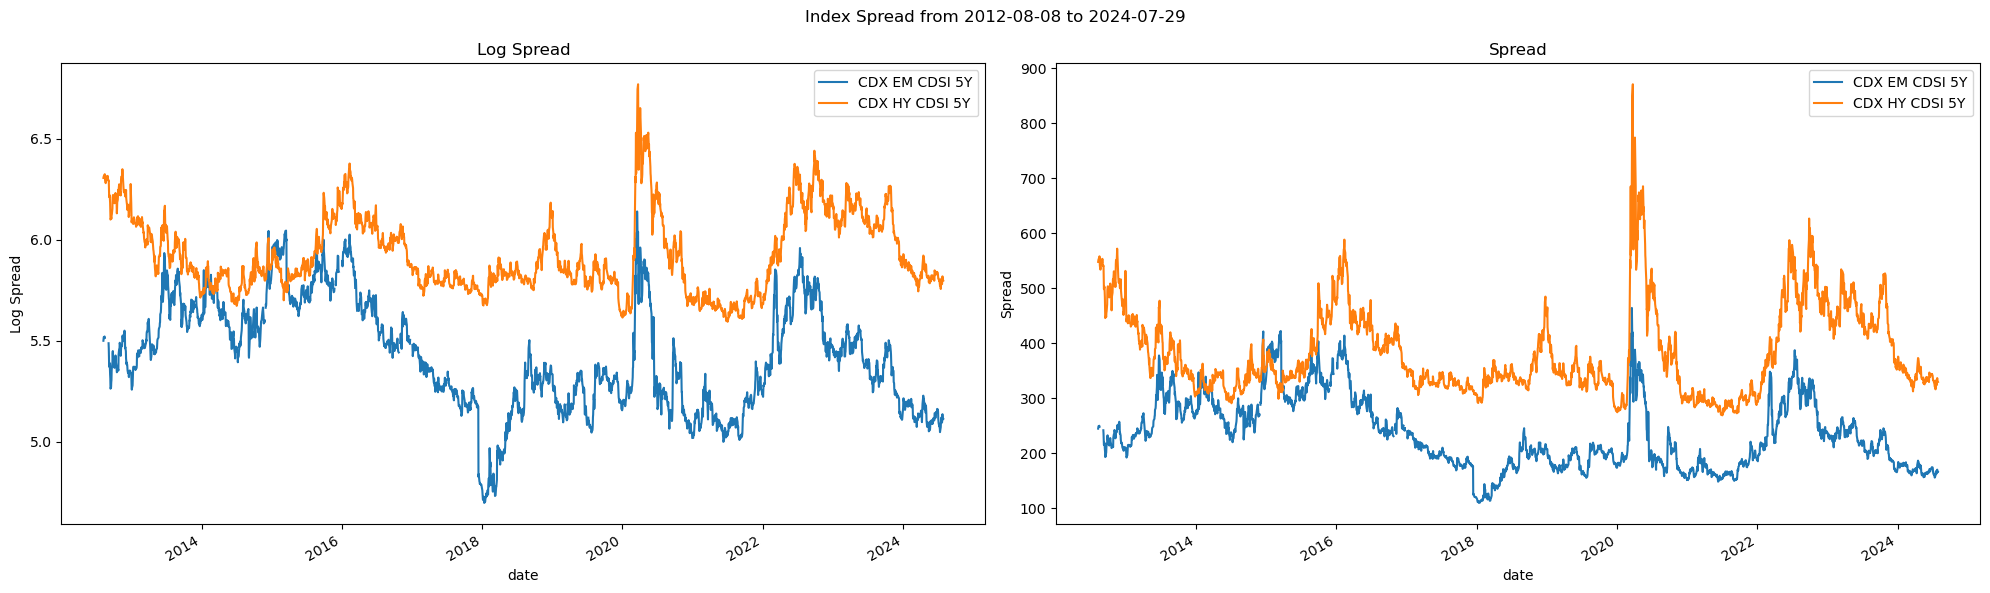

In [6]:
def plot_spread(df_cds: pd.DataFrame) -> plt.Figure: 

    df_plot = (df_cds.drop(
        columns = ["px"]).
        melt(id_vars = ["date", "security"]).
        rename(columns = {"security": ""}).
        pivot(index = ["date", "variable"], columns = "", values = "value").
        reset_index())
    
    renamer = {
        "log_spread": "Log Spread",
        "spread"    : "Spread"}
    
    variables = df_plot.variable.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_plot.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            set_index("date").
            plot(
                ax     = ax,
                title  = renamer[variable],
                ylabel = renamer[variable]))
    
    fig.suptitle("Index Spread from {} to {}".format(
        df_plot.date.min().date(),
        df_plot.date.max().date()))
    
    plt.tight_layout()

plot_spread(df_cds)

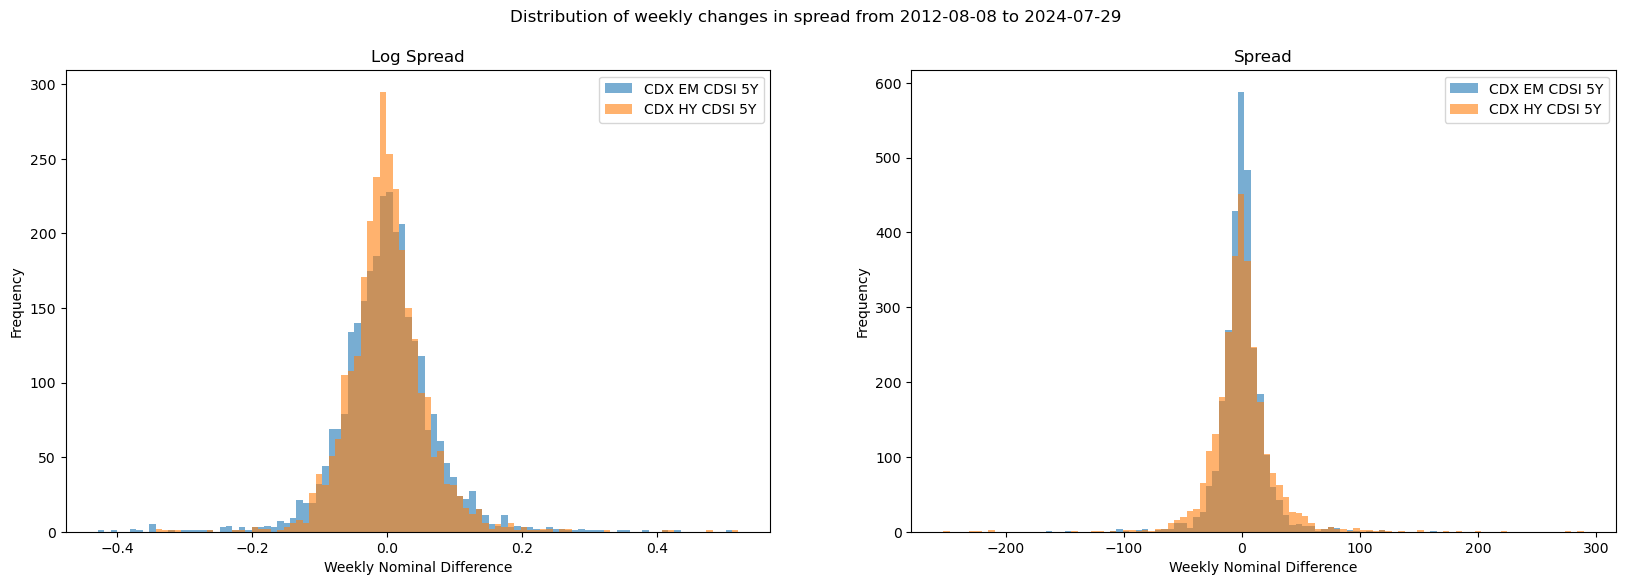

In [7]:
def plot_spread_difference(df_cds: pd.DataFrame) -> plt.Figure: 

    df_plot = (df_cds.drop(
        columns = ["px"]).
        melt(id_vars = ["date", "security"]).
        rename(columns = {"security": ""}).
        pivot(index = ["date", "variable"], columns = "", values = "value").
        reset_index())
    
    renamer = {
        "log_spread": "Log Spread",
        "spread"    : "Spread"}
    
    variables = df_plot.variable.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_plot.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            set_index("date").
            sort_index().
            diff(periods = 5).
            dropna().
            plot(
                ax     = ax,
                kind   = "hist",
                bins   = 100,
                alpha  = 0.6,
                title  = renamer[variable],
                xlabel = "Weekly Nominal Difference"))

    fig.suptitle("Distribution of weekly changes in spread from {} to {}".format(
        df_plot.date.min().date(),
        df_plot.date.max().date()))

plot_spread_difference(df_cds)

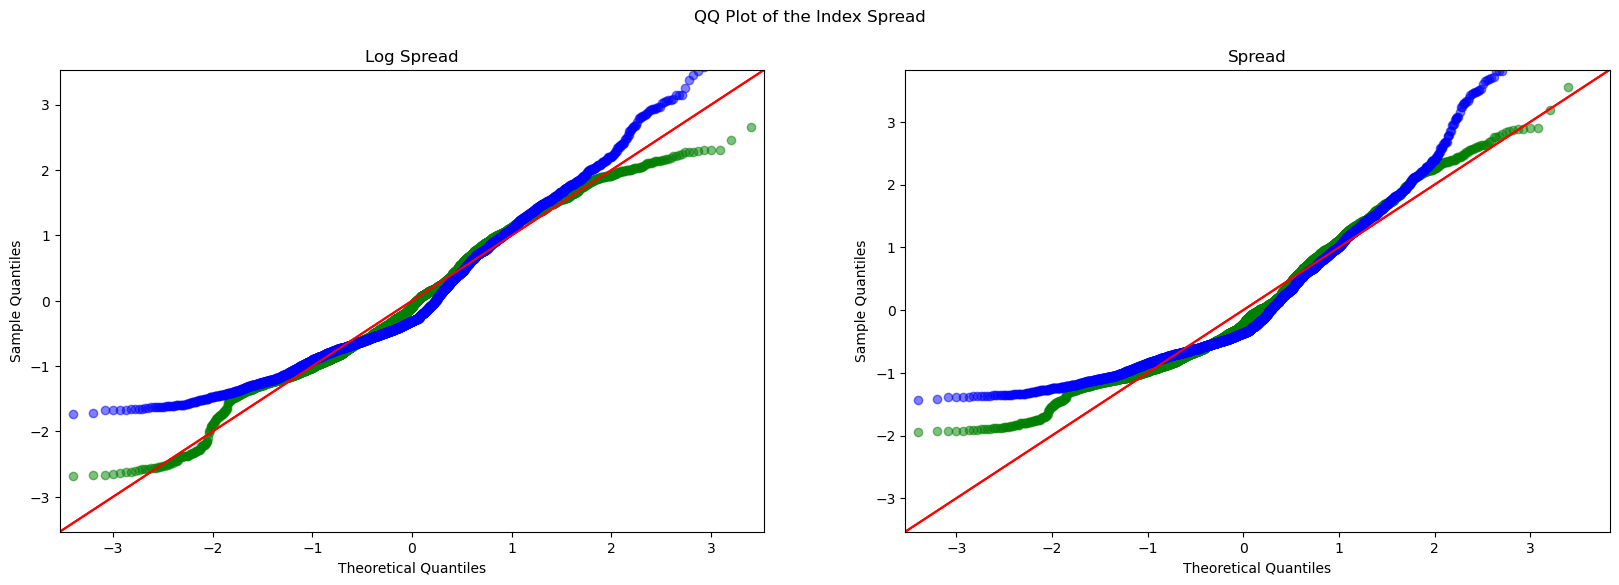

In [8]:
def plot_qq(df_cds: pd.DataFrame) -> plt.Figure: 

    df_plot = (df_cds.drop(
        columns = ["px"]).
        melt(id_vars = ["date", "security"]).
        rename(columns = {"security": ""}).
        pivot(index = ["date", "variable"], columns = "", values = "value").
        reset_index())
    
    variables = df_plot.variable.drop_duplicates().to_list()
    
    renamer = {
        "spread": "Spread",
        "log_spread": "Log Spread"} 
    
    colors = {
        "CDX EM CDSI 5Y": "green",
        "CDX HY CDSI 5Y": "blue"}
    
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    for variable, ax in zip(variables, axes.flatten()):
    
        df_wider = (df_plot.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            set_index("date").
            dropna())
    
        for col in df_wider.columns:
    
            qqplot(
                data            = df_wider[col], 
                fit             = True, 
                line            = "45",
                ax              = ax,
                markerfacecolor = colors[col],
                markeredgecolor = colors[col],
                alpha           = 0.5,
                label           = col)
    
        ax.set_title(renamer[variable])
    
    fig.suptitle("QQ Plot of the Index Spread")
    
plot_qq(df_cds)